## The Data

 Below are the descriptions contained in that data dictionary:

- PassengerID - A column added by Kaggle to identify each row and make submissions easier
- Survived - Whether the passenger survived or not and the value we are predicting (0=No, 1=Yes)
- Pclass - The class of the ticket the passenger purchased (1=1st, 2=2nd, 3=3rd)
- Sex - The passenger's sex
- Age - The passenger's age in years
- SibSp - The number of siblings or spouses the passenger had aboard the Titanic
- Parch - The number of parents or children the passenger had aboard the Titanic
- Ticket - The passenger's ticket number
- Fare - The fare the passenger paid
- Cabin - The passenger's cabin number
- Embarked - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)

The type of machine learning we will be doing is called classification, because when we make predictions we are classifying each passenger as a survivor or not. More specifically, we are performing binary classification, which means that there are only two different states we are classifying.


In [1]:
import pandas as pd

test = pd.read_csv("titanic_test.csv")
test_shape = test.shape
train = pd.read_csv("titanic_train.csv")
train_shape = train.shape

In [2]:
print(test_shape)
print(train_shape)

(418, 11)
(891, 12)


In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploring The Data

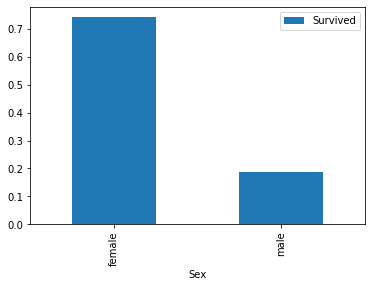

In [3]:
import matplotlib.pyplot as plt

sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.bar()
plt.show()

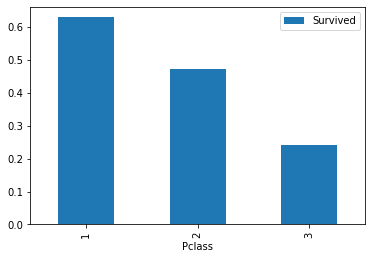

In [5]:
class_pivot = train.pivot_table(index="Pclass",values="Survived")
class_pivot.plot.bar()
plt.show()

In [6]:
print(train["Age"].describe())

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


The Age column contains numbers ranging from 0.42 to 80.0 (if you look at Kaggle's data page, it informs us that Age is fractional if the passenger is less than one). The other thing to note here is that there are 714 values in this column, fewer than the 891 rows we discovered that the train data set had earlier in this mission which indicates we have some missing values.

Let's create two histograms to compare visually those that survived vs those who died across different age ranges:

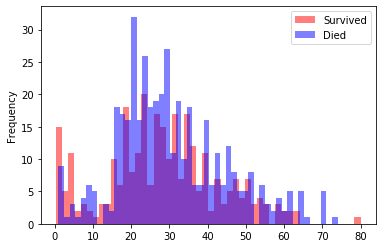

In [7]:
survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.show()

The relationship here is not simple, but we can see that in some age ranges more passengers survived - where the red bars are higher than the blue bars.

In order for this to be useful to our machine learning model, we can separate this continuous feature into a categorical feature by dividing it into ranges. We can use the pandas.cut() function to help us out

## Converting the Age Column Into Categorical

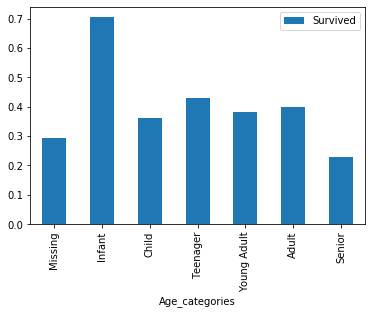

In [12]:
#we create a function that:
#uses the pandas.fillna() method to fill all of the missing values with -0.5
#cuts the Age column into segments using pandas.cut().

def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df
#Create the cut_points and label_names lists to split the Age column into six categories
cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]

train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)

pivot = train.pivot_table(index="Age_categories",values='Survived')
pivot.plot.bar()
plt.show()

In [13]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_categories
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Young Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Young Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Young Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Young Adult


## Preparing Our Data For Machine Learning

So far we have identified three columns that may be useful for predicting survival:
- Sex
- Pclass
- Age, or more specifically our newly created Age_categories


In [14]:
train["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

Before we build our model, we need to prepare these columns for machine learning. Most machine learning algorithms can't understand text labels, so we have to convert our values into numbers.

To achieve this we'll use the pandas.get_dummies() function.

In [15]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

col = ["Pclass","Sex","Age_categories"]
for column in col:
    train = create_dummies(train,column)
    test = create_dummies(test,column)


In [25]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Pclass_3,Sex_female,Sex_male,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,...,1,0,1,0,0,0,0,1,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,...,1,1,0,0,0,0,0,0,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,...,0,0,1,0,0,0,0,0,0,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,...,1,0,1,0,0,0,0,1,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,...,1,1,0,0,0,0,0,1,0,0


## Creating The First ML Model

Let's train our model using all of the columns we just created.

In [17]:
from sklearn.linear_model import LogisticRegression

columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

lr = LogisticRegression() #Instantiate a LogisticRegression object called lr
lr.fit(train[columns], train["Survived"])#Use LogisticRegression.fit() to fit the model on the train dataset 

LogisticRegression()

## Splitting Our Training Data 

If you recall from earlier, we do have a test dataframe that we could use to make predictions. We could make predictions on that data set, but because it doesn't have the Survived column we would have to submit it to Kaggle to find out our accuracy. This would quickly become a pain if we had to submit to find out the accuracy every time we optimized our model.

We'll now divide our train data into two parts- one for training and another for testing. Alos we'll rename the kaggle test data as **holdout**.

In [18]:
holdout = test # from now on we will refer to this dataframe as the holdout data to avoid confusion

from sklearn.model_selection import train_test_split

columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']
all_X = train[columns]
all_y = train['Survived']

train_X, test_X, train_y, test_y = train_test_split(
    all_X, all_y, test_size=0.20,random_state=0)

## Measuring Accuracy

In [19]:
from sklearn.metrics import accuracy_score
lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)
accuracy = accuracy_score(test_y, predictions)
print(accuracy)

0.8100558659217877


## Using Cross Validation For More Accurate Error Measurement

In [20]:
from sklearn.model_selection import cross_val_score
import numpy as np

#Instantiate a new LogisticRegression() object, lr
lr = LogisticRegression()

#Use model_selection.cross_val_score() to perform cross-validation on our data 
#Specify 10 folds to be used
scores = cross_val_score(lr, all_X, all_y, cv=10)

#Use the numpy.mean() function to calculate the mean of scores
accuracy = np.mean(scores)
print(scores)
print(accuracy)

[0.8        0.82022472 0.76404494 0.87640449 0.80898876 0.78651685
 0.76404494 0.76404494 0.83146067 0.80898876]
0.8024719101123596


## Making Predictions On Unseen Data

In [21]:
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

lr = LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions = lr.predict(holdout[columns])

## Creating a Submission File For Kaggle

In [22]:
holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission.csv",index=False)

## Preparing More Features

Now we shall embark on a new journey of improving the accuracy of our predictions.

There are two main areas we can focus on:
- Improving the features we train our model on
- Improving the model itself

Let's start by looking at feature selection

In [27]:
import pandas as pd

train = pd.read_csv('titanic_train.csv')
holdout = pd.read_csv('titanic_test.csv')

def process_age(df):
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df
train = process_age(train)
holdout = process_age(holdout)

for column in ["Age_categories","Pclass","Sex"]:
    train = create_dummies(train,column)
    holdout = create_dummies(holdout,column)

print(train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male'],
      dtype='object')


We can ignore PassengerId, since this is just a column used to identify each passenger and calculate scores. We can also ignore Survived, as this is what we're predicting, as well as the three columns we've already used.

Here is a list of the remaining columns (with a brief description):
- SibSp - The number of siblings or spouses the passenger had aboard the Titanic
- Parch - The number of parents or children the passenger had aboard the Titanic
- Ticket - The passenger's ticket number
- Fare - The fair the passenger paid
- Cabin - The passengers cabin number
- Embarked - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)

In [28]:
#We can use the Dataframe.describe() method 
#to give us some more information on the values within each remaining column.
columns = ['SibSp','Parch','Fare','Cabin','Embarked']
print(train[columns].describe(include='all',percentiles=[]))

             SibSp       Parch        Fare Cabin Embarked
count   891.000000  891.000000  891.000000   204      889
unique         NaN         NaN         NaN   147        3
top            NaN         NaN         NaN    G6        S
freq           NaN         NaN         NaN     4      644
mean      0.523008    0.381594   32.204208   NaN      NaN
std       1.102743    0.806057   49.693429   NaN      NaN
min       0.000000    0.000000    0.000000   NaN      NaN
50%       0.000000    0.000000   14.454200   NaN      NaN
max       8.000000    6.000000  512.329200   NaN      NaN


Of these, SibSp, Parch and Fare look to be standard numeric columns with no missing values. Cabin has values for only 204 of the 891 rows, and even then most of the values are unique, so for now we will leave this column also. 

Embarked looks to be a standard categorical column with 3 unique values, much like PClass was, except that there are two missing values. We can easily fill these two missing values with the most common value, "S" which occurs 644 times.

In order to make sure that the values of our colums are equally weighted within our model, we'll need to **rescale** the data- since **Fare** is on a dramatically different scale, with values ranging from 0-512.

In [29]:
from sklearn.preprocessing import minmax_scale
# The holdout set has a missing value in the Fare column which
# we'll fill with the mean.
holdout["Fare"] = holdout["Fare"].fillna(train["Fare"].mean())
columns = ["SibSp","Parch","Fare"]

train["Embarked"] = train["Embarked"].fillna("S")
holdout["Embarked"] = holdout["Embarked"].fillna("S")

train = create_dummies(train,"Embarked")
holdout = create_dummies(holdout,"Embarked")

for col in columns:
    train[col + "_scaled"] = minmax_scale(train[col])
    holdout[col + "_scaled"] = minmax_scale(holdout[col])

## Determining The Most Relevant Features

In order to select the best-performing features, we need a way to measure which of our features are relevant to our outcome - in this case, the survival of each passenger.

One effective way is by training a logistic regression model using all of our features, and then looking at the coefficients of each feature.

Let's now fit a model and plot the coefficients for each feature.

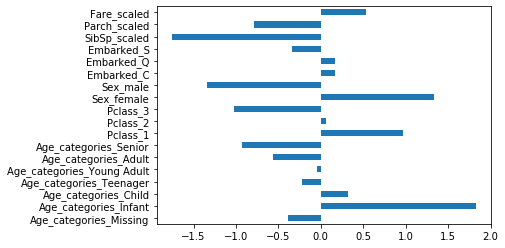

In [30]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']
lr = LogisticRegression()
lr.fit(train[columns],train['Survived'])

coefficients = lr.coef_

feature_importance = pd.Series(coefficients[0],
                               index=train[columns].columns)
feature_importance.plot.barh()
plt.show()

To make things easier to interpret, we'll alter the plot to show all positive values, and have sorted the bars in order of size:

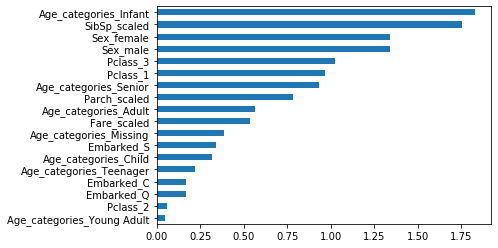

In [31]:
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh()
plt.show()

We'll train a new model with the top 8 scores and check our accuracy using cross validation.

In [32]:
from sklearn.model_selection import cross_val_score

columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']
all_X = train[columns]
all_y = train['Survived']

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = scores.mean()
print(accuracy)

0.8148064918851435


The cross validation score of 81.48% is marginally higher than the cross validation score for the model we created earlier, which had a score of 80.2%.

Let's train a model using the above columns 

In [33]:
columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']

all_X = train[columns]
all_y = train['Survived']
lr = LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions = lr.predict(holdout[columns])

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission_1.csv",index=False)

## Engineering A New Feature Using Binning

One common way to engineer a feature is using a technique called binning.

We'll create a function **process_fare()** that uses the pandas **cut()** method to create bins for the Fare column and assign the results to a new column called **Fare_categories**.

In [34]:
def process_fare(df,cut_points,label_names):
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

cut_points = [0,12,50,100,1000]
label_names = ["0-12","12-50","50-100","100+"]

train = process_fare(train,cut_points,label_names)
holdout = process_fare(holdout,cut_points,label_names)

train = create_dummies(train,"Fare_categories")
holdout = create_dummies(holdout,"Fare_categories")

In [35]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked_Q,Embarked_S,SibSp_scaled,Parch_scaled,Fare_scaled,Fare_categories,Fare_categories_0-12,Fare_categories_12-50,Fare_categories_50-100,Fare_categories_100+
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,1,0.125,0.0,0.014151,0-12,1,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,0.125,0.0,0.139136,50-100,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,1,0.000,0.0,0.015469,0-12,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,0.125,0.0,0.103644,50-100,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,1,0.000,0.0,0.015713,0-12,1,0,0,0


## Engineering Features From Text Colums

In [50]:
train[['Name','Cabin']].sample(n=10)

,Name,Cabin
397,"McKane, Mr. Peter David",NaN
432,"Louch, Mrs. Charles Alexander (Alice Adelaide ...",NaN
134,"Sobey, Mr. Samuel James Hayden",NaN
824,"Panula, Master. Urho Abraham",NaN
218,"Bazzani, Miss. Albina",D15
62,"Harris, Mr. Henry Birkhardt",C83
456,"Millet, Mr. Francis Davis",E38
4,"Allen, Mr. William Henry",NaN
248,"Beckwith, Mr. Richard Leonard",D35
271,"Tornquist, Mr. William Henry",NaN


While in isolation the cabin number of each passenger will be reasonably unique to each, we can see that the format of the cabin numbers is one letter followed by two numbers. It seems like the letter is representative of the type of cabin, which could be useful data for us.

Looking at the Name column, There is a title like 'Mr' or 'Mrs' within each, as well as some less common titles, like the 'Countess' from the final row of our table above. By spending some time researching the different titles, we can categorize these into six types: Mr, Mrs, Master, Mis, Officer, and Royalty.

We'll use the **Series.str.extract** method and a regular expression to extract the title from each name and then use the **Series.map()** method and a predefined dictionary to simplify the titles.

In [43]:
#extract titles from the Name Column
extracted_titles = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)

In [47]:
extracted_titles.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [51]:
# create a predefined dictionary to simplify the titles.
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

#create a new column Titles to save the simplified titles in the train datafram
train["Title"] = extracted_titles.map(titles)

#repeate the above for the holdout data frame
extracted_titles = holdout["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
holdout["Title"] = extracted_titles.map(titles)

In [52]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked_S,SibSp_scaled,Parch_scaled,Fare_scaled,Fare_categories,Fare_categories_0-12,Fare_categories_12-50,Fare_categories_50-100,Fare_categories_100+,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,1,0.125,0.0,0.014151,0-12,1,0,0,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0.125,0.0,0.139136,50-100,0,0,1,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1,0.000,0.0,0.015469,0-12,1,0,0,0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,0.125,0.0,0.103644,50-100,0,0,1,0,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,1,0.000,0.0,0.015713,0-12,1,0,0,0,Mr


Now let's engineer the Cabin column

In [53]:
#xtract the first letter from the Cabin column and assign the result to a new column Cabin_type
#fill any missing values in Cabin_type with "Unknown"

train["Cabin_type"] = train["Cabin"].str[0]
train["Cabin_type"] = train["Cabin_type"].fillna("Unknown")

holdout["Cabin_type"] = holdout["Cabin"].str[0]
holdout["Cabin_type"] = holdout["Cabin_type"].fillna("Unknown")

#For the newly created columns Title and Cabin_type
#create dummy columns for both the train and holdout dataframes.

for column in ["Title","Cabin_type"]:
    train = create_dummies(train,column)
    holdout = create_dummies(holdout,column)

In [83]:
holdout.head(n=5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Title_Officer,Title_Royalty,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_Unknown
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,...,0,0,0,0,0,0,0,0,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,...,0,0,0,0,0,0,0,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,...,0,0,0,0,0,0,0,0,0,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,...,0,0,0,0,0,0,0,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,...,0,0,0,0,0,0,0,0,0,1


## Finding Correlated Features

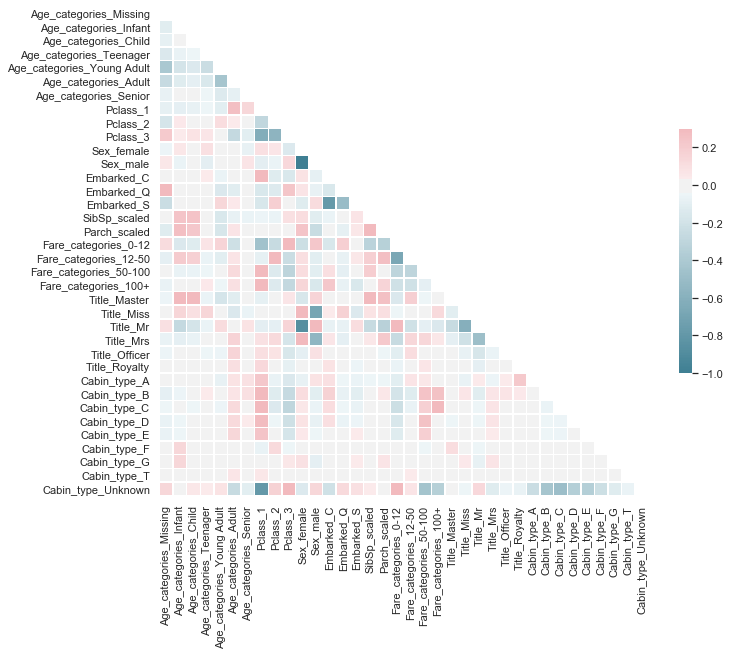

In [56]:
import numpy as np
import seaborn as sns

def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
       'Fare_categories_12-50','Fare_categories_50-100', 'Fare_categories_100+',
       'Title_Master', 'Title_Miss', 'Title_Mr','Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A','Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E','Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']
plot_correlation_heatmap(train[columns])

## Final Feature Selection Using RFECV

In [58]:
from sklearn.feature_selection import RFECV

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled',
       'Parch_scaled', 'Fare_categories_0-12', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown']

all_X = train[columns]
all_y = train["Survived"]
lr = LogisticRegression()
selector = RFECV(lr,cv=10)
selector.fit(all_X,all_y)

optimized_columns = all_X.columns[selector.support_]

In [59]:
optimized_columns

Index(['SibSp_scaled', 'Title_Mr', 'Title_Officer', 'Cabin_type_Unknown'], dtype='object')

## Training The Model Using The Optimized Features

In [60]:
all_X = train[optimized_columns]
all_y = train["Survived"]
lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = scores.mean()

In [61]:
accuracy

0.8226591760299625

This four-feature model scores 82.3%, a modest improvement compared to the 81.5% from our earlier model.
 Let's train these columns on the holdout set

In [63]:
lr = LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions = lr.predict(holdout[optimized_columns])

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission_2.csv",index=False)

## Some Ideas For Further Improvement

Here are some ideas that you can use to work with features even more:
- Use SibSp and Parch to explore total relatives onboard.
- Create combinations of multiple columns, for instance Pclass + Sex.
- See if you can extract useful data out of the Ticket column.
- Try different combinations of features to see if you can identify features that overfit less than others.

# Model Selection And Tuning

The process of selecting the algorithm which gives the best predictions for your data is called **model selection**.

We're going to work with two new algorithms: **k-nearest neighbors** and **random forests**.

We're going to train our models using all the columns in the train dataframe. We shall exclude: Survived, and PassengerId. 

In [70]:
columns = ['Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'SibSp_scaled', 'Parch_scaled', 'Fare_scaled',
       'Fare_categories_0-12', 'Fare_categories_12-50',
       'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty',
       'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T',
       'Cabin_type_Unknown']

len(columns)

37

### Logistic regression baseline

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

all_X = train[columns]
all_y = train['Survived']
lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy_lr = scores.mean()
accuracy_lr

0.8249812734082397

### K-Nearest Neighhours

In [74]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)

scores = cross_val_score(knn, all_X, all_y, cv=10)
accuracy_knn = scores.mean()
accuracy_knn

0.7833832709113608

Besides pure model selection, we can vary the settings of each model— for instance the value of k in our k-nearest neighbors model. This is called hyperparameter optimization.

**Let's try to explore different K's**

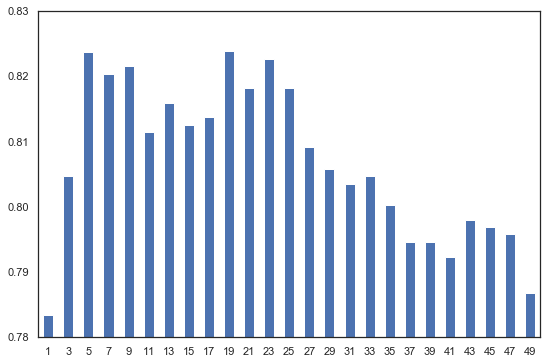

In [75]:
import matplotlib.pyplot as plt

def plot_dict(dictionary):
    pd.Series(dictionary).plot.bar(figsize=(9,6),
                                   ylim=(0.78,0.83),rot=0)
    plt.show()

knn_scores = dict()
for k in range(1,50,2):
    knn = KNeighborsClassifier(n_neighbors=k)

    scores = cross_val_score(knn, all_X, all_y, cv=10)
    accuracy_knn = scores.mean()
    knn_scores[k] = accuracy_knn

plot_dict(knn_scores)

### Grid Search

Looking at our plot from the previous screen we can see that a k value of 19 gave us our best score, and checking the knn_scores dictionary we can see that the score was 82.4%.

The technique we just used is called grid search - we train a number of models across a 'grid' of values and then searched for the model that gave us the highest accuracy.

In [77]:
from sklearn.model_selection import GridSearchCV

hyperparameters = {
    "n_neighbors": range(1,20,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute'],
    "p": [1,2]
}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn,param_grid=hyperparameters,cv=10)

grid.fit(all_X, all_y)

best_params = grid.best_params_
best_score = grid.best_score_
best_score

0.8293882646691635

The cross-validation score for the best performing model was 82.7%, better than our baseline model.

Next, let's use the **GridSearchCV.best_estimator_** attribute to retrieve a trained model with the best-performing hyperparameters.

In [96]:
columns = ['Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'SibSp_scaled', 'Parch_scaled', 'Fare_scaled',
       'Fare_categories_0-12', 'Fare_categories_12-50',
       'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty',
       'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T',
       'Cabin_type_Unknown']

holdout['Cabin_type_T'] = [0]*holdout.shape[0] #add a column for 'Cabin_type_T'
holdout_no_id = holdout[columns]
best_knn = grid.best_estimator_
holdout_predictions = best_knn.predict(holdout_no_id)

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission_3.csv",index=False)

When we submit this to Kaggle, we noticed it scored 75.6%, less than our best submission of 78.0%. While our model could be overfitting due to including all columns, it also seems like k-nearest neighbors may not be the best algorithm choice.

Let's try another algorithm called **random forests**: a specific type of decision tree algorithm.

Let's use a **RandomForestClassifier** object with **cross_val_score()** as we did earlier to see how the algorithm performs with the default hyperparameters.

### Random Forests

In [98]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=1)
scores = cross_val_score(clf, all_X, all_y, cv=10)
accuracy_rf = scores.mean()
accuracy_rf

0.8204119850187267

Using the default settings, our random forests model obtained a cross validation score of 82.0%.

Just like we did with the k-nearest neighbors model, let's use **GridSearchCV** to test a variety of hyperparameters to find the best performing model.

In [100]:
#Let's use grid search to test out combinations of the following hyperparameters:
hyperparameters = {"criterion": ["entropy", "gini"],
                   "max_depth": [5, 10],
                   "max_features": ["log2", "sqrt"],
                   "min_samples_leaf": [1, 5],
                   "min_samples_split": [3, 5],
                   "n_estimators": [6, 9]
}

clf = RandomForestClassifier(random_state=1)
grid = GridSearchCV(clf,param_grid=hyperparameters,cv=10)

grid.fit(all_X, all_y)

best_params = grid.best_params_
best_score = grid.best_score_
best_score

0.838414481897628

The cross-validation score for the best performing model was 84.3%, making it the best cross-validation score we've obtained this far.

Let's train it on the holdout data and create a submission file to see how it performs on the Kaggle leaderboard!

In [102]:
best_rf = grid.best_estimator_
holdout_predictions = best_rf.predict(holdout_no_id)

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission_4.csv",index=False)